# Time-series prediction of renewable energy production

In [2]:
from datetime import datetime, timedelta
from app.tasks.generation import generation as generation_task
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler

In [3]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)

In [4]:
data = pd.read_csv('../data/generation_2017.csv').set_index('timestamp')

In [5]:
def split_train_test(ds, ratio=2/3):
    train_length = int(ratio * len(ds))
    return ds[:train_length], ds[train_length:]
    
def create_datasets(ds, lookback=1):
    """
    Create two datasets for training: X = input, Y = output.
    Y is just a time-shifted version of X. The lookback argument
    tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)


In [10]:
lookback = 3
model_df = data[['renewables', 'non_renewables']]
dataset = model_df.as_matrix()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_ds, test_ds = split_train_test(dataset)
train_x, train_y = create_datasets(train_ds, lookback)
test_x, test_y = create_datasets(test_ds, lookback)

In [26]:
model = Sequential()
model.add(LSTM(32, input_shape=(lookback, 2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(train_x, train_y, epochs=30, batch_size=16, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 - 3s - loss: 0.0197
Epoch 2/30
 - 1s - loss: 0.0042
Epoch 3/30
 - 2s - loss: 0.0036
Epoch 4/30
 - 2s - loss: 0.0029
Epoch 5/30
 - 1s - loss: 0.0020
Epoch 6/30
 - 2s - loss: 0.0015
Epoch 7/30
 - 2s - loss: 0.0014
Epoch 8/30
 - 2s - loss: 0.0013
Epoch 9/30
 - 1s - loss: 0.0013
Epoch 10/30
 - 1s - loss: 0.0012
Epoch 11/30
 - 2s - loss: 0.0012
Epoch 12/30
 - 1s - loss: 0.0011
Epoch 13/30
 - 2s - loss: 0.0011
Epoch 14/30
 - 2s - loss: 0.0011
Epoch 15/30
 - 1s - loss: 0.0010
Epoch 16/30
 - 2s - loss: 9.9865e-04
Epoch 17/30
 

In [27]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score:.2} MSE ({math.sqrt(train_score):.2} RMSE)')
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score:.2} MSE ({math.sqrt(test_score):.2} RMSE)')


Train Score: 0.00099 MSE (0.031 RMSE)
Test Score: 0.0013 MSE (0.036 RMSE)


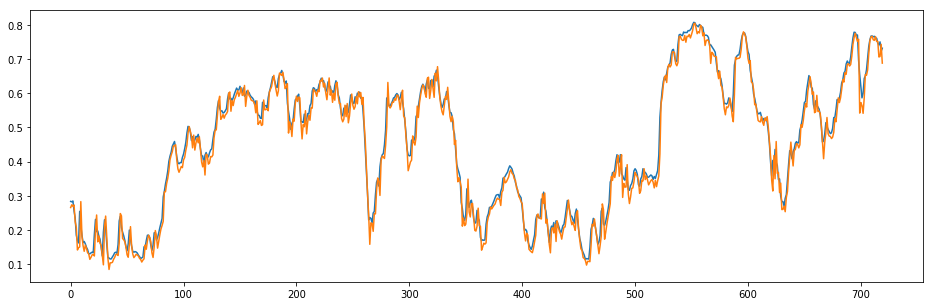

In [49]:
test_predict = model.predict(test_x)
test_predict = scaler.inverse_transform(test_predict)
test_predict = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict]

real = model_df[-720:].apply(pd.Series).reset_index(drop=True)
real['ratio'] = real['renewables'] / (real['renewables'] + real['non_renewables'])

plt.plot(real['ratio'])
plt.plot(test_predict[-720:])
plt.show()

In [39]:
[x / (x + y) for x, y in test_predict]

[0.21094646,
 0.20417072,
 0.19975147,
 0.18588823,
 0.16366142,
 0.12853347,
 0.092959844,
 0.099844955,
 0.1046791,
 0.10490645,
 0.11060298,
 0.1130236,
 0.11938357,
 0.14131448,
 0.13254949,
 0.13692342,
 0.1895311,
 0.25948501,
 0.31894147,
 0.37025046,
 0.37843442,
 0.35821697,
 0.32930699,
 0.32638624,
 0.29575956,
 0.25702196,
 0.22809815,
 0.16054642,
 0.13974708,
 0.17797039,
 0.1871089,
 0.15348111,
 0.1507435,
 0.15617828,
 0.17008266,
 0.19740517,
 0.17984049,
 0.18455893,
 0.23325872,
 0.28428143,
 0.33815292,
 0.3721399,
 0.37430248,
 0.35704544,
 0.37117156,
 0.36033472,
 0.34981126,
 0.31371465,
 0.22542286,
 0.14568947,
 0.0950756,
 0.17498599,
 0.12941311,
 0.14582999,
 0.16177869,
 0.17829145,
 0.1966771,
 0.26322365,
 0.24381877,
 0.25517163,
 0.32594496,
 0.38735306,
 0.41868645,
 0.4416666,
 0.48976105,
 0.49489206,
 0.48905641,
 0.46632859,
 0.4391979,
 0.39945772,
 0.33200258,
 0.30146199,
 0.22170629,
 0.22183259,
 0.25901532,
 0.1754365,
 0.20625173,
 0.21906

blue: real data

green: prediction


### References

* https://keras.io/getting-started/sequential-model-guide/
* https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
